# Example of relative scale estimation using image box embeddings
This notebook gives example code to estimate the relative scale between two **test** images using estimated enclosure and concentration.

In [1]:
import os
import torch

import numpy as np
import PIL.Image as pil
import matplotlib.pyplot as plt

from src.model import ResnetEncoder
from src.utils import box_overlap, checkpoint_loader, download_model_if_doesnt_exist
from torchvision import transforms

# Load and visualize pair of test images

Text(0.5, 1.0, 'Image y')

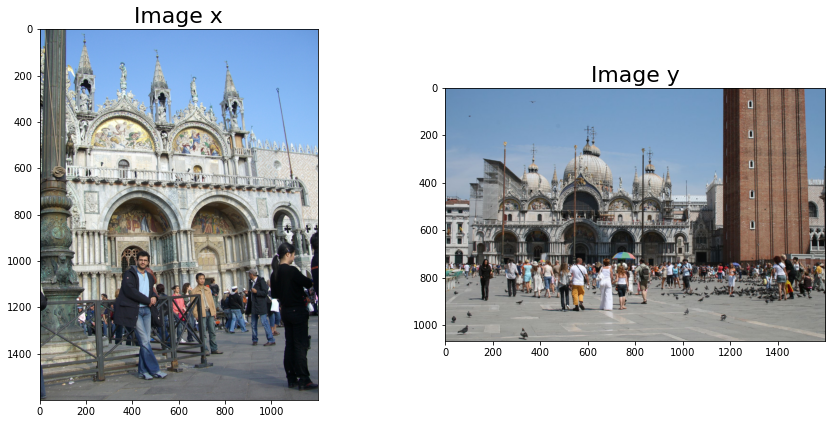

In [2]:
image_path_x = 'data/examples/venice_1.jpg'  # 457935319_81e555455d_o.jpg (original megadepth filename)
image_x = pil.open(image_path_x).convert('RGB')
image_path_y = 'data/examples/venice_2.jpg'  # 1350271066_36d07d8d94_o.jpg
image_y = pil.open(image_path_y).convert('RGB')

plt.figure(figsize=(15, 15))
plt.subplot(221)
plt.imshow(image_x)
plt.title("Image x", fontsize=22)
plt.subplot(222)
plt.imshow(image_y)
plt.title("Image y", fontsize=22)

# Setting up network, loading weights and converting to PyTorch tensors

In [3]:
model_name = "venice"  # options: venice, bigben, notredame, florence
download_model_if_doesnt_exist(model_name)
state_dict = checkpoint_loader(os.path.join("models", model_name, model_name + '.pth.tar'))
model = ResnetEncoder(num_layers=50, box_ndim=32)
model.load_state_dict(state_dict)
model.eval()

x_width, x_height = image_x.size
y_width, y_height = image_y.size

feed_width, feed_height = 456, 256

image_x_tensor = transforms.ToTensor()(image_x.resize((feed_width, feed_height), pil.ANTIALIAS)).unsqueeze(0)
image_y_tensor = transforms.ToTensor()(image_y.resize((feed_width, feed_height), pil.ANTIALIAS)).unsqueeze(0)

# Computing the box embedding of each image

In [4]:
with torch.no_grad():
    bx_center, bx_extent = model(image_x_tensor)
    by_center, by_extent = model(image_y_tensor)

# Predicting visual overlap from image x to y and vice versa

In [5]:
[enclosure] = box_overlap(bx_center, bx_extent, by_center, by_extent).cpu().numpy()
[concentration] = box_overlap(by_center, by_extent, bx_center, bx_extent).cpu().numpy()

Enclosure is the percentage of pixels from image x that are visible in image y:

In [6]:
print("Enclosure: {:.1f}%".format(100*enclosure))

Enclosure: 83.2%


Concentration is the percentage of pixels from image y that are visible in image x:

In [7]:
print("Concentration: {:.1f}%".format(100*concentration))

Concentration: 14.9%


# Compute relative scale and show result

In [8]:
def compute_relative_scale(enclosure, concentration, x_width, x_height, y_width, y_height):
    x_area = x_width * x_height
    y_area = y_width * y_height

    x_scale, y_scale = 1, 1

    ratio = enclosure / concentration

    y_scale = np.sqrt(ratio * x_area / y_area)

    if y_scale > 1:  # we want to downsample, not upsample
        x_scale = 1 / y_scale
        y_scale = 1

    return x_scale, y_scale

x_scale, y_scale = compute_relative_scale(enclosure, concentration, x_width, x_height, y_width, y_height)

In [9]:
image_x_resized = image_x.resize((int(x_scale*x_width), int(x_scale*x_height)), pil.ANTIALIAS)
image_y_resized = image_y.resize((int(y_scale*y_width), int(y_scale*y_height)), pil.ANTIALIAS)

Text(0.5, 1.0, 'Image y')

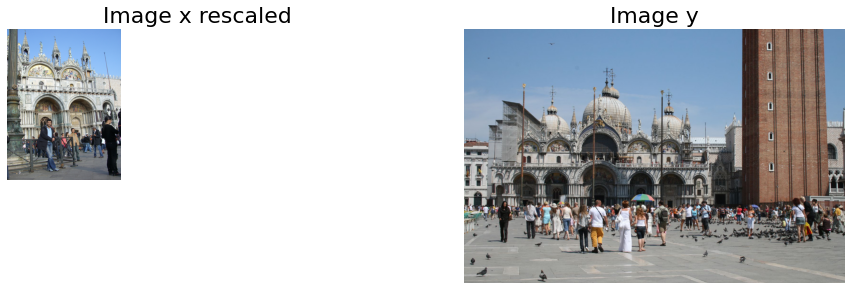

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(15,15))
ax[0].imshow(image_x_resized)
ax[0].axis('off')
ax[0].set_title('Image x rescaled', fontsize=22)
ax[1].imshow(image_y_resized)
ax[1].axis('off')
ax[1].set_title('Image y', fontsize=22)

The rescaled image should now show the overlapping scene at similar resolution!